# 1. Import the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [6]:
from bs4 import BeautifulSoup
import spacy

In [11]:
nlp = spacy.load('en_core_web_sm')

# Read the data(news.csv)

In [3]:
df =pd.read_csv("news.csv")
df.head()

,news_headline,news_article,news_category,full_text,clean_text
0,Instagram testing ₹89 monthly subscriptions fo...,Instagram is testing a new subscription featur...,technology,Instagram testing ₹89 monthly subscriptions fo...,instagram test monthly subscription exclusive ...
1,Instagram begins testing 'Take a Break' feature,Instagram has started testing a new feature ca...,technology,Instagram begins testing 'Take a Break' featur...,instagram begin test take break feature instag...
2,"Mother of 5 dies after her Tesla hits boulder,...",A mother of five children died after her Tesla...,technology,"Mother of 5 dies after her Tesla hits boulder,...",mother die tesla hit boulder tree catch fire u...
3,SpaceX launches Indian-American Raja Chari-led...,SpaceX and NASA launched four astronauts into ...,technology,SpaceX launches Indian-American Raja Chari-led...,spacex launch indian american raja chari lead ...
4,"Apple computer hand-built by Steve Jobs, Wozni...","An Apple-1 computer, that was hand-built by co...",technology,"Apple computer hand-built by Steve Jobs, Wozni...",apple computer hand build steve jobs wozniak s...


## Tag Parts of Speech

In [14]:
sentence = str(df.iloc[1]['news_headline'])
sentence_nlp = nlp(sentence)

In [15]:
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,Instagram,NNP,PROPN
1,begins,VBZ,VERB
2,testing,VBG,VERB
3,',``,PUNCT
4,Take,VB,VERB
5,a,DT,DET
6,Break,NN,NOUN
7,',POS,PART
8,feature,NN,NOUN


## Named Entity Recognition

Identify the named entities for the first news article.

In [16]:
sentence = str(df.iloc[1].full_text)

In [17]:
sentence

"Instagram begins testing 'Take a Break' feature. Instagram has started testing a new feature called 'Take a Break' that allows users to opt-in for in-app break reminders. The feature encourages them to take a break from Instagram after a certain amount of time - 10 minutes, 20 minutes or 30 minutes. Instagram will also offer tips for breaks and advice on how to frame taking a break."

In [18]:
sentence_nlp = nlp(sentence)

In [19]:
sentence_nlp

Instagram begins testing 'Take a Break' feature. Instagram has started testing a new feature called 'Take a Break' that allows users to opt-in for in-app break reminders. The feature encourages them to take a break from Instagram after a certain amount of time - 10 minutes, 20 minutes or 30 minutes. Instagram will also offer tips for breaks and advice on how to frame taking a break.

In [20]:
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

[(', 'WORK_OF_ART'), (Take, 'WORK_OF_ART'), (a, 'WORK_OF_ART'), (Break, 'WORK_OF_ART'), (', 'WORK_OF_ART'), (Instagram, 'ORG'), (', 'WORK_OF_ART'), (Take, 'WORK_OF_ART'), (a, 'WORK_OF_ART'), (Break, 'WORK_OF_ART'), (', 'WORK_OF_ART'), (Instagram, 'ORG'), (time, 'TIME'), (-, 'TIME'), (10, 'TIME'), (minutes, 'TIME'), (,, 'TIME'), (20, 'TIME'), (minutes, 'TIME'), (or, 'TIME'), (30, 'TIME'), (minutes, 'TIME'), (Instagram, 'ORG')]


# Emotion and Sentiment Analysis

Perform sentiment analyis on all the news articles.

In [41]:
from afinn import Afinn
import unicodedata
import re
from nltk.tokenize.toktok import ToktokTokenizer
import nltk

In [42]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [28]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

In [43]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [33]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

In [34]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [44]:
corpus = normalize_corpus(df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

In [45]:
af = Afinn()

In [46]:
sentiment_scores = [af.score(article) for article in corpus]

In [48]:
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

In [49]:
df_sen = pd.DataFrame([list(df['news_category']), sentiment_scores, sentiment_category]).T

In [50]:
df_sen.columns = ['news_category', 'sentiment_score', 'sentiment_category']

In [51]:
df_sen['sentiment_score'] = df_sen.sentiment_score.astype('float')

In [53]:
df_sen.groupby(by=['news_category']).describe()

sentiment_score                                                 
                        count      mean        std   min   25%  50%  75%   max
news_category                                                                 
sports                   24.0  1.166667  11.126415 -28.0 -2.75  2.5  9.0  19.0
technology               24.0  0.750000   4.513265 -11.0 -1.25  2.0  4.0   8.0
world                    25.0 -2.240000   9.225327 -15.0 -8.00 -4.0  3.0  25.0

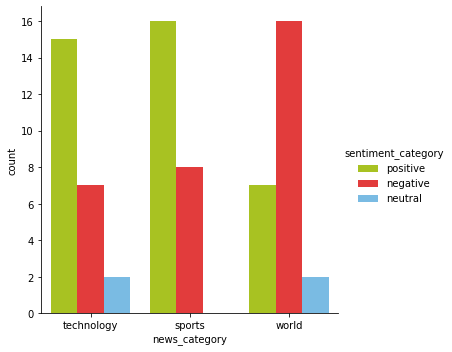

In [56]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df_sen, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})